Import Modules

In [1]:

import glob
import json
import os
import sys


import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from scipy import ndimage
from tensorflow.keras import layers, backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.models import Model


from keras.utils import load_img
from IPython.display import display
from sklearn.utils.class_weight import compute_class_weight


Load annotations file created by VGG Image Annotator and create colored masks for each image

In [2]:


with open('Dataset/annotated_test.json', 'r') as file:
    annotations = json.load(file)


# Define colors for each class
colors = {
    "breech-face impression": (0, 0, 255),     # Red
    "aperture shear": (0, 255, 0),             # Green
    "firing pin impression": (255, 0, 255),    # Purple
    "firing pin drag": (255, 191, 0)           # Light Blue
}


output_dir = 'Dataset/test_masks_initial'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


for image_id, image_data in annotations['_via_img_metadata'].items():
    filename = image_data['filename']
    image_path = os.path.join("Dataset/Test/", filename)
    original_image = cv2.imread(image_path)
    
    if original_image is None:
        continue


    mask = np.zeros_like(original_image)

    #Assiging a color to each region
    for region in image_data['regions']:
        all_points_x = region['shape_attributes']['all_points_x']
        all_points_y = region['shape_attributes']['all_points_y']

        points = np.array([all_points_x, all_points_y]).T
        points = points.reshape((-1, 1, 2))

        label = region['region_attributes']['Label']
        color = colors.get(label, (0, 0, 0))  # balck for background

       
        cv2.fillPoly(mask, [points], color)

    
    mask_filename = os.path.splitext(filename)[0] + '.png'
    cv2.imwrite(os.path.join(output_dir, mask_filename), mask)




Assign a class label to eachpixel of the colored_mask created in the previous cell

In [43]:


# map RGB pixel to a label
def map_color_to_class(color):
    if np.array_equal(color, [0, 0, 0]):
        return 0  # Background
    elif np.array_equal(color, [0, 0, 255]):
        return 1  # breech-face impression
    elif np.array_equal(color, [0, 255, 0]):
        return 2  # aperture shear
    elif np.array_equal(color, [255, 0, 255]):
        return 3  # firing pin impression
    elif np.array_equal(color, [255, 191, 0]):
        return 4  # firing pin drag
    else:
        return -1  # Unrecognized color

input_dir = 'Dataset/test_masks_initial'
output_dir = 'Dataset/test_masks'

if not os.path.exists(input_dir):
    print("Input directory not found:", input_dir)
else:
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path)

            if image is None:
                print(f"Error: Unable to read - {filename}")
            else:
                class_array = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                for i in range(image.shape[0]):
                    for j in range(image.shape[1]):
                        class_array[i, j] = map_color_to_class(image[i, j])

                
                output_file_path = os.path.join(output_dir, filename)
                cv2.imwrite(output_file_path, class_array)  

print("Processing complete. Masks saved to", output_dir)
               
                


KeyboardInterrupt: 

Print the number of training images and their correponding mask

In [3]:
input_dir_train = "Dataset/Train"
target_dir_train = "Dataset/masks"

input_img_paths_train = sorted(
    [
        os.path.join(input_dir_train, fname)
        for fname in os.listdir(input_dir_train)
        if fname.endswith(".jpg")
    ]
)
target_img_paths_train = sorted(
    [
        os.path.join(target_dir_train, fname)
        for fname in os.listdir(target_dir_train)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths_train))

for input_path, target_path in zip(input_img_paths_train[:3], target_img_paths_train[:3]):
    print(input_path, "|", target_path)

Number of samples: 61
Dataset/Train\1.jpg | Dataset/masks\1.png
Dataset/Train\10.jpg | Dataset/masks\10.png
Dataset/Train\11.jpg | Dataset/masks\11.png


Display an image along with its corresponding mask

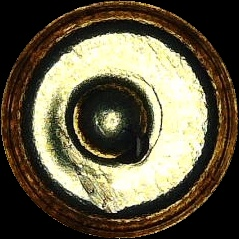

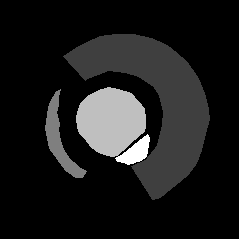

In [4]:

display(Image.open(input_img_paths_train[51]))


img = ImageOps.autocontrast(Image.open(target_img_paths_train[51]))
display(img)

Function defined for data augmentation

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(.5, .2)],
  
  )

Preparing the dataset

Training data

In [6]:
IMAGE_SIZE = 224
num_classes = 5
batch = 2
LR = 1e-4
EPOCHS = 20

image_path = "Dataset/Train/"
mask_path = "Dataset/masks/"


def load_data():

  TRAIN_X = sorted(glob.glob(os.path.join(image_path + "*.jpg")))
  train_x = TRAIN_X[:]
  TRAIN_Y = sorted(glob.glob(os.path.join(mask_path +  "*.png")))
  train_y = TRAIN_Y[:]

  return (train_x, train_y)

(train_x, train_y) = load_data() 

For Evaluation data

In [7]:
image_path = "Dataset/Eval/"
mask_path = "Dataset/eval_masks/"


def load_data():

  EVAL_X = sorted(glob.glob(os.path.join(image_path + "*.jpg")))
  eval_x = EVAL_X[:]
  EVAL_Y = sorted(glob.glob(os.path.join(mask_path +  "*.png")))
  eval_y = EVAL_Y[:]


  return (eval_x, eval_y)

(eval_x, eval_y) = load_data() 

Test data

In [8]:

image_path = "Dataset/Test/"
mask_path = "Dataset/test_masks/"


def load_data():

  TEST_X = sorted(glob.glob(os.path.join(image_path + "*.jpg")))
  test_x = TEST_X[:]
  TEST_Y = sorted(glob.glob(os.path.join(mask_path +  "*.png")))
  test_y = TEST_Y[:]


  return (test_x, test_y)

(test_x, test_y) = load_data() 

Create Tensorflow datasets

For train data

In [9]:
#resizing the image
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    return x

# resizing the mask
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

# Apply augmentation

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)

    
        y = tf.cast(y, tf.float32)
        
        
        combined = tf.concat([x, y], axis=-1)
        combined = data_augmentation(combined)
        
        
        x = combined[..., :3]
        y = combined[..., 3:]
        y = tf.cast(y, tf.uint8)  

        
        x = tf.cast(x, tf.float64)
        y = tf.cast(y, tf.uint8)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

# Dataset creation function
def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset


train_dataset = tf_dataset(train_x, train_y)



For test and evaluation data

In [10]:
#resizing the image
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    return x

# resizing the mask
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

# Apply augmentation

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

# Dataset creation function
def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset



eval_dataset = tf_dataset(eval_x, eval_y)
test_dataset = tf_dataset(test_x, test_y)


Defining the Unet model

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=5):

    #Encoder
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Decoder
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [12]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=5)

# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)


<keras.src.engine.input_layer.InputLayer object at 0x000001836666C8D0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001837A7F5450> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x0000018366676210> False
<keras.src.layers.activation.relu.ReLU object at 0x0000018366AA0850> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x00000183659A0510> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001836597FC50> False
<keras.src.layers.activation.relu.ReLU object at 0x00000183666BEBD0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000018366A38950> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000183666DDAD0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000183659A2850> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001836598EA10> Fal

Compiling the model

In [13]:

opt = tf.keras.optimizers.Adam(LR)
metrics = ['accuracy']
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=metrics)

# early stopping and reduce learning rate 
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.00001,
)

# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = 'my_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# class_weights are calculated to be taken into account during the training to help the model learn the small segments better
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
class_weight_dict = dict(enumerate(class_weights))


Training the model

In [15]:
train_steps = len(train_x)//batch
valid_steps = len(eval_x)//batch
print(len(eval_x))

if len(train_x) % batch != 0: 
    train_steps += 1
if len(eval_x) % batch != 0: 
    valid_steps += 1

print(valid_steps)
model.fit(
    train_dataset,
    class_weight=class_weight_dict,
    validation_data = eval_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)

10
5
Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.5605INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 75s 2s/step - loss: 1.2550 - accuracy: 0.5605 - val_loss: 0.7542 - val_accuracy: 0.7928 - lr: 1.0000e-04
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8812INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 73s 2s/step - loss: 0.5163 - accuracy: 0.8812 - val_loss: 0.5287 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 3/20
31/31 [==============================] - 64s 2s/step - loss: 0.3375 - accuracy: 0.8993 - val_loss: 0.4831 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 4/20
31/31 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.9047INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 74s 2s/step - loss: 0.2898 - accuracy: 0.9047 - val_loss: 0.3462 - val_accuracy: 0.9036 - lr: 1.0000e-04
Epoch 5/20
31/31 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9105INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 85s 3s/step - loss: 0.2611 - accuracy: 0.9105 - val_loss: 0.2911 - val_accuracy: 0.9126 - lr: 1.0000e-04
Epoch 6/20
31/31 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.9078INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 59s 2s/step - loss: 0.2634 - accuracy: 0.9078 - val_loss: 0.2703 - val_accuracy: 0.9187 - lr: 1.0000e-04
Epoch 7/20
31/31 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9165INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 49s 2s/step - loss: 0.2327 - accuracy: 0.9165 - val_loss: 0.2533 - val_accuracy: 0.9211 - lr: 1.0000e-04
Epoch 8/20
31/31 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9233INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 49s 2s/step - loss: 0.2182 - accuracy: 0.9233 - val_loss: 0.2708 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 9/20
31/31 [==============================] - 43s 1s/step - loss: 0.2063 - accuracy: 0.9269 - val_loss: 0.2759 - val_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 10/20
31/31 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9293INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 49s 2s/step - loss: 0.1961 - accuracy: 0.9293 - val_loss: 0.2508 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 11/20
31/31 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9291INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 49s 2s/step - loss: 0.1943 - accuracy: 0.9291 - val_loss: 0.2609 - val_accuracy: 0.9263 - lr: 1.0000e-04
Epoch 12/20
31/31 [==============================] - 43s 1s/step - loss: 0.1911 - accuracy: 0.9292 - val_loss: 0.2425 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 13/20
31/31 [==============================] - 43s 1s/step - loss: 0.1844 - accuracy: 0.9321 - val_loss: 0.2554 - val_accuracy: 0.9258 - lr: 1.0000e-04
Epoch 14/20
31/31 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9302INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 50s 2s/step - loss: 0.1874 - accuracy: 0.9302 - val_loss: 0.2143 - val_accuracy: 0.9339 - lr: 2.0000e-05
Epoch 15/20
31/31 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9332INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 50s 2s/step - loss: 0.1791 - accuracy: 0.9332 - val_loss: 0.2197 - val_accuracy: 0.9340 - lr: 2.0000e-05
Epoch 16/20
31/31 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9342INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


31/31 [==============================] - 50s 2s/step - loss: 0.1758 - accuracy: 0.9342 - val_loss: 0.2108 - val_accuracy: 0.9349 - lr: 2.0000e-05
Epoch 17/20
31/31 [==============================] - 43s 1s/step - loss: 0.1760 - accuracy: 0.9351 - val_loss: 0.2084 - val_accuracy: 0.9342 - lr: 2.0000e-05
Epoch 18/20
31/31 [==============================] - 43s 1s/step - loss: 0.1793 - accuracy: 0.9327 - val_loss: 0.2100 - val_accuracy: 0.9346 - lr: 2.0000e-05
Epoch 19/20
31/31 [==============================] - 43s 1s/step - loss: 0.1758 - accuracy: 0.9339 - val_loss: 0.2092 - val_accuracy: 0.9348 - lr: 1.0000e-05


In [32]:
checkpoint_filepath = 'my_model'

model = tf.keras.models.load_model(checkpoint_filepath)

1/1 [==============================] - 0s 195ms/step


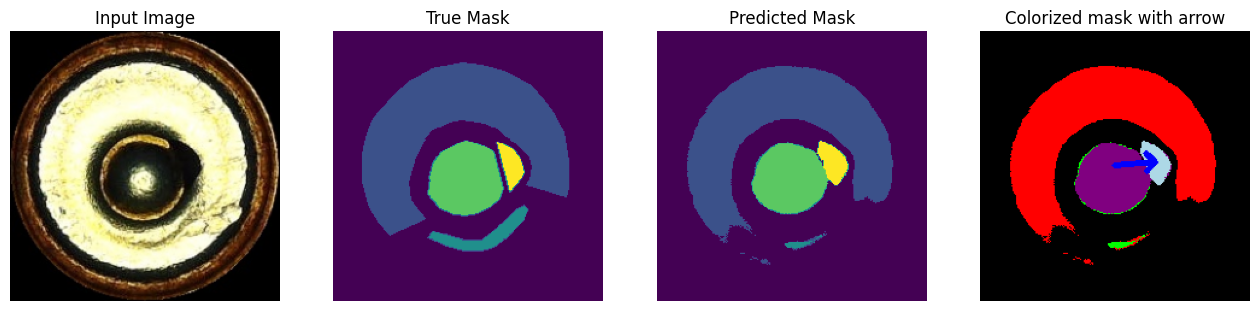

1/1 [==============================] - 0s 203ms/step


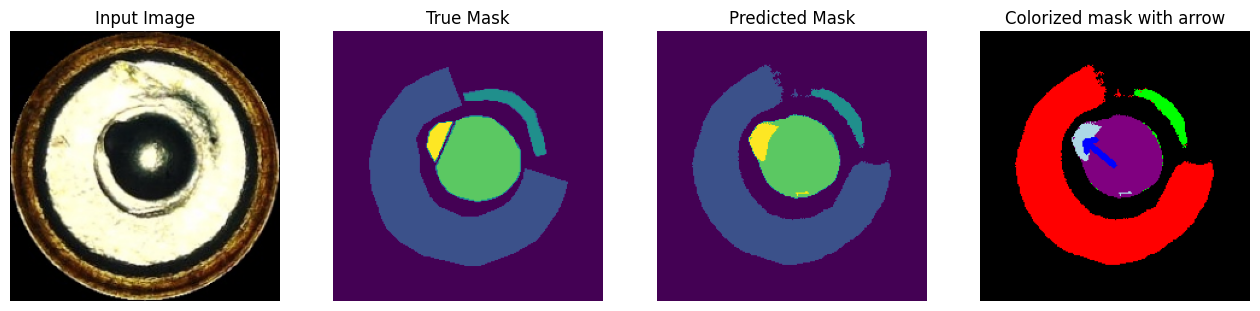

1/1 [==============================] - 0s 226ms/step


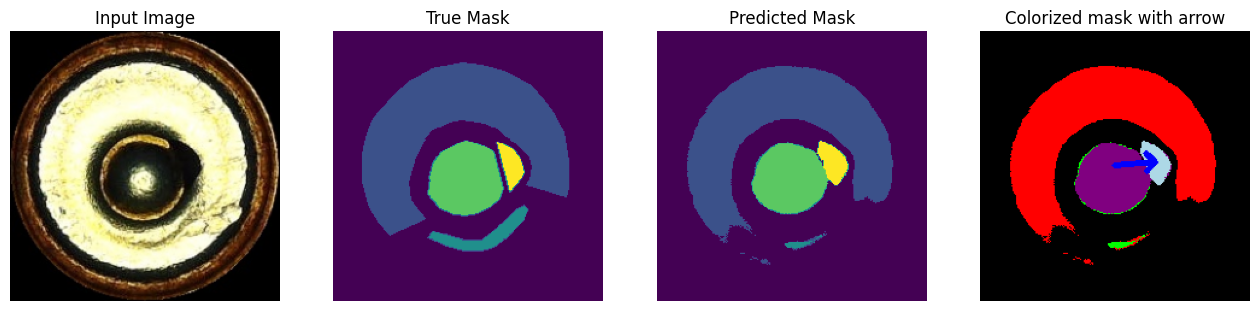

1/1 [==============================] - 0s 186ms/step


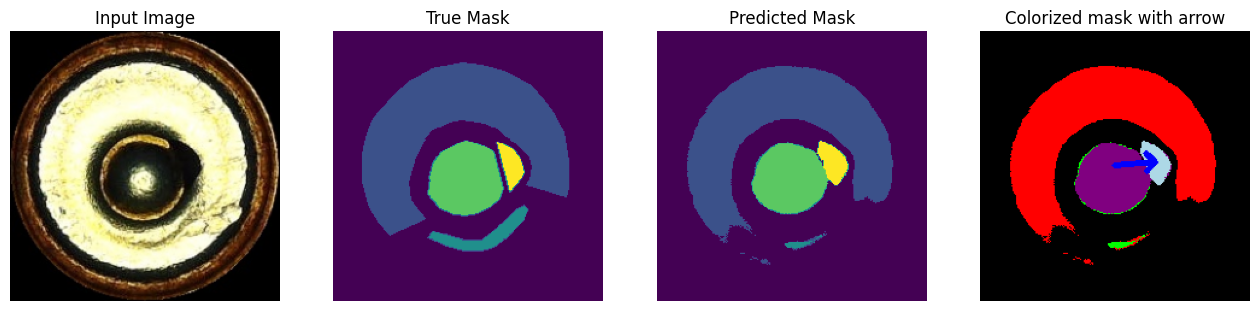

1/1 [==============================] - 0s 196ms/step


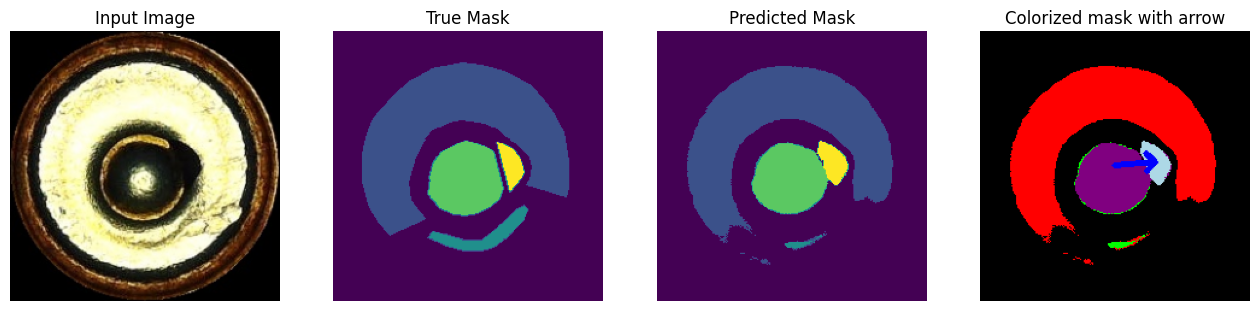

1/1 [==============================] - 0s 181ms/step


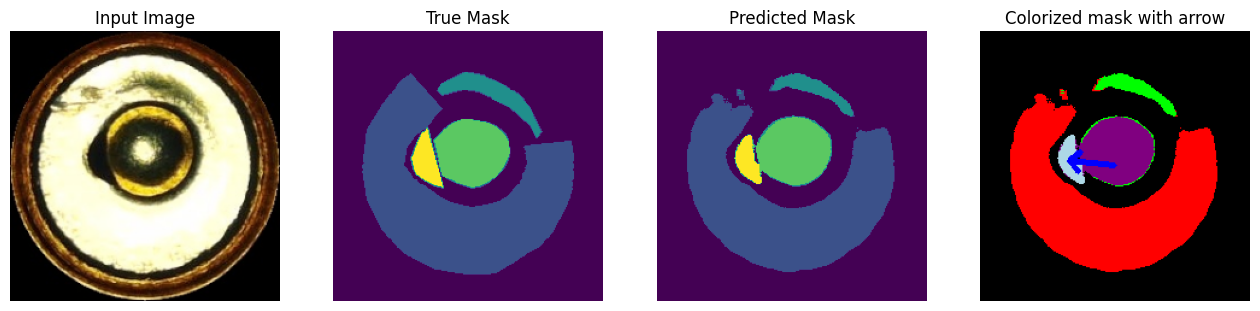

1/1 [==============================] - 0s 188ms/step


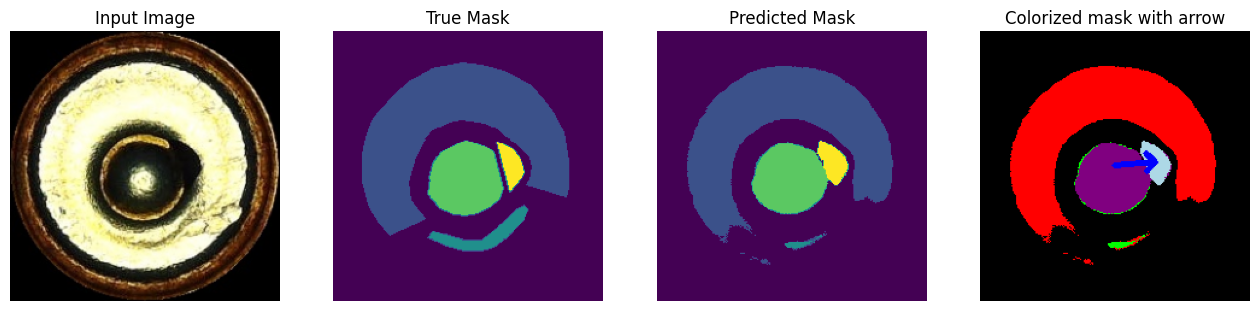

1/1 [==============================] - 0s 179ms/step


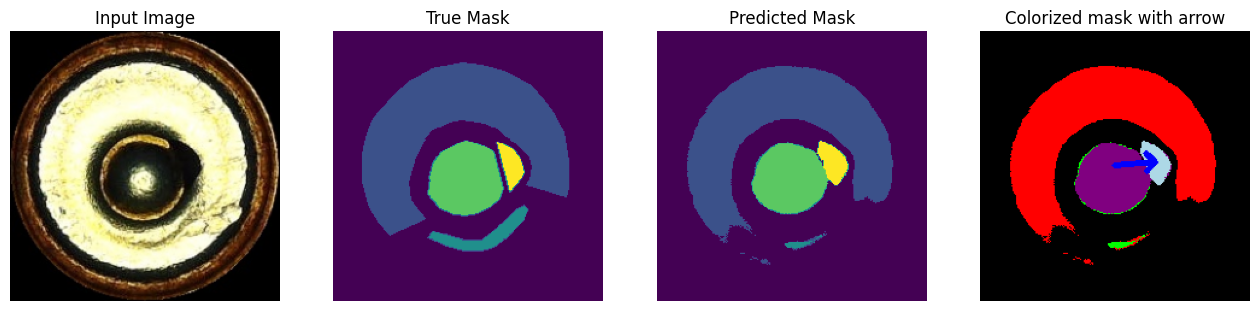

1/1 [==============================] - 0s 196ms/step


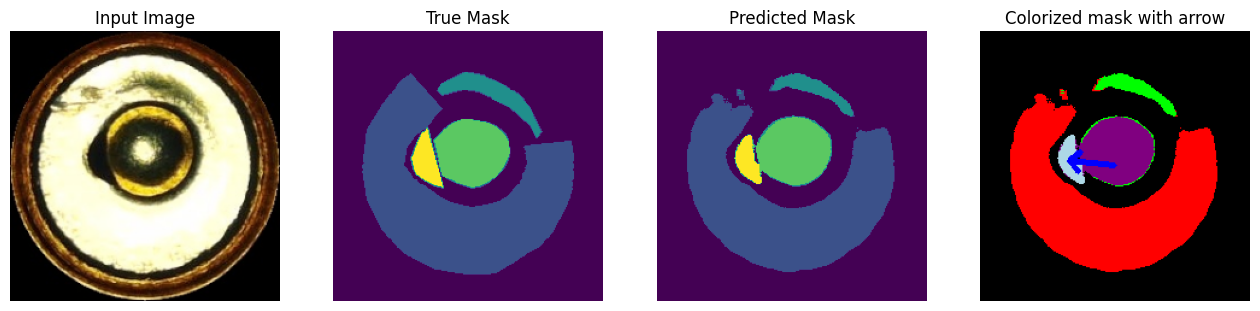

1/1 [==============================] - 0s 186ms/step


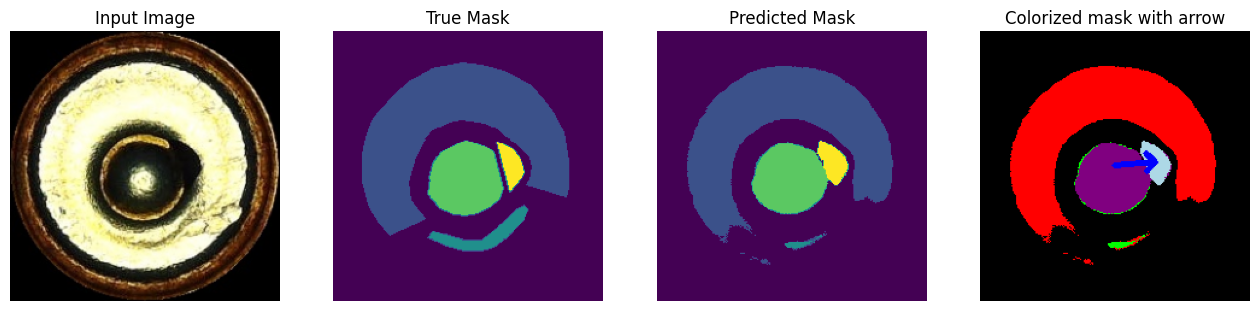

In [60]:
# Create the msk from the prediction made by unet
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask


def colorize_mask(mask):
    "This function is only defined for colorizing the mask (if needed)"
    
    colors = {
        0: [0, 0, 0],        # Background (Black)
        1: [255, 0, 0],      # Class 1 (Red)
        2: [0, 255, 0],      # Class 2 (Green)
        3: [128, 0, 128],    # Class 3 (Purple)
        4: [173, 216, 230]   # Class 4 (Light Blue)
    }

   
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls, color in colors.items():
        colored_mask[mask[:, :, 0] == cls] = color

    return colored_mask

# for displayng the input image in rgb
def bgr_to_rgb(image):
    return image[..., ::-1] 

def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Colorized mask with arrow']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


def calculate_centroid(mask, class_id=None):
    if class_id is not None:
        # Extract the coordinates of friring pin drag pixels
        coords = np.column_stack(np.where(mask[:, :, 0] == class_id))
    else:
        # Use all pixels if class_id is None
        coords = np.column_stack(np.indices(mask.shape[:2]))
    
    centroid = coords.mean(axis=0).astype(int)
    return (centroid[1], centroid[0])  # Return as (x, y)

def draw_arrow(image, start_point, end_point, color, thickness=3, tip_length=0.3):
    
    image = cv2.arrowedLine(image, start_point, end_point, color, thickness, tipLength=tip_length)
    return image

def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...]
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    colored_mask = colorize_mask(pred_mask[0])
    

    centroid_image = calculate_centroid(pred_mask[0])  # Centroid of the image
    centroid_class_0 = calculate_centroid(pred_mask[0], 4)  # Centroid of class firing pin drag
    
    # Draw arrow on the colored mask
    colored_mask_with_arrow = draw_arrow(
        colored_mask, 
        centroid_image, 
        centroid_class_0, 
        color=(0, 0, 255),  
    )
    
    
    display_sample([bgr_to_rgb(sample_image[0]), sample_mask[0], pred_mask[0], colored_mask_with_arrow])

# Iterate through the test dataset
for image, mask in test_dataset.take(10):
    sample_image, sample_mask = image, mask
    show_predictions()


    



Applying colorized mask to the original image

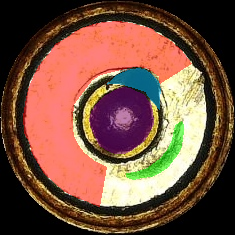

In [61]:


original_image = cv2.imread('Dataset/Train/1.jpg')
mask_image = cv2.imread('Dataset/masks/1.png', 0)  # 0 for grayscale



colors = {
    1: (0, 0, 255),    # Class 1: Red
    2: (0, 255, 0),    # Class 2: Green
    3: (128, 0, 128),  # Class 3: Purple
    4: (255, 191, 0) # Class 4: Light Blue
}


segmented_image = np.zeros_like(original_image)


for class_id, color in colors.items():
    class_mask = (mask_image == class_id)
    segmented_image[class_mask] = color


background_mask = (mask_image == 0)
segmented_image[background_mask] = original_image[background_mask]


#Transparency

alpha = 0.5
beta = 1 - alpha
blended_image = cv2.addWeighted(segmented_image, alpha, original_image, beta, 0)


blended_image = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)
image_to_display = display(Image.fromarray(blended_image))



